# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>


During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters, $\sigma$, which is the width of the two Gaussians under square root, and $\mu$, which represents the distance from the origin of their average values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import system
from time import time
from matplotlib.pyplot import figure

In [2]:
start_all = time()

### Exercise 08.1

Write a C++ Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample a trial wave function $|\Psi_T(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$ (Suggestion: as a starting point, you can use the code you have already developed for the Hydrogen atom or the Monte Carlo NVT code). Using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity.

In [3]:
start = time()
system('sh clean.sh')
system('./VCM.exe')
end = time()
print('-- Time of computation:', int((end-start)*1000)/1000, 'sec')

-- Time of computation: 0.39 sec


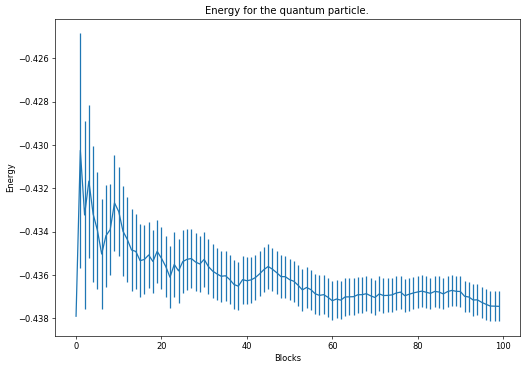

In [4]:
y = np.loadtxt('output.Hamiltonian.0')
x = np.arange(len(y))

#plt.style.use('classic')
figure(num=None, figsize=(10, 7), dpi=60, facecolor='w', edgecolor='k')

plt.errorbar(x, y[:,2], yerr=y[:,3])
plt.title('Energy for the quantum particle.')
plt.xlabel('Blocks')
plt.ylabel('Energy')
plt.show()

### Exercise 08.2

Use your Variational Monte Carlo code to find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$:

$$
\langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

- As usual, <span style="color:red">show a picture of the estimation of $\langle {\hat H} \rangle_T$ </span> and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$

In [5]:
mu = 0.70
sigma = 0.5
min_energy = 1.

min_mu = mu
min_sigma = sigma

l = 10

In [6]:
start = time()
while(mu < 0.82):
    mu = mu + 0.01
    sigma = 0.5
    while(sigma < 0.7):
        sigma = sigma + 0.01
        
        system('sh clean.sh')
        system('./VCM.exe ' +str(sigma) +' '+str(mu))
        y = np.loadtxt('output.Hamiltonian.0')
        x = np.arange(len(y))
        final_energy = y[-1,3]
        
        if final_energy < min_energy:
            min_energy = final_energy
            min_mu = mu
            min_sigma = sigma
            
end = time()
print('-- Time of computation: ', int((end-start)*100)/100,'sec')          

-- Time of computation:  97.93 sec


In [7]:
min_sigma = int(min_sigma*1000)/1000

In [8]:
print("μ:", min_mu, "\nσ:",min_sigma)

μ: 0.77 
σ: 0.61


In [9]:
system('sh clean.sh')
system('./VCM.exe ' +str(min_sigma) +' '+str(min_mu))
y = np.loadtxt('output.Hamiltonian.0')
x = np.arange(len(y))

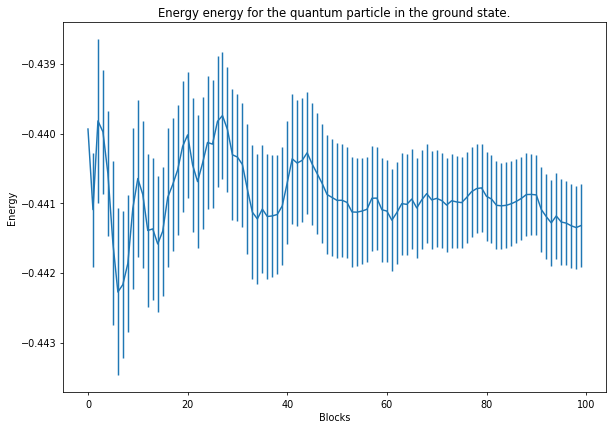

In [10]:
figure(num=None, figsize=(10, 7), dpi=70, facecolor='w', edgecolor='k')
plt.errorbar(x, y[:,2], yerr=y[:,3])
plt.title('Energy energy for the quantum particle in the ground state.')
plt.xlabel('Blocks')
plt.ylabel('Energy')
plt.show()

- <span style="color:red">show also a picture **of the sampled** $|\Psi_T(x)|^2$</span> by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below).

In [11]:
histo = np.loadtxt('output.histo.0')
y = histo[:,2]
x = histo[:,0]
err = histo[:,3]

In [12]:
def wave_function_sq(x, mu, sigma):
    a = np.exp( - (x-mu)**2./(2.*sigma**2.) ) + np.exp( - (x+mu)**2./(2.*sigma**2.) ) 
    b = np.sqrt(2. * np.sqrt(np.pi) *sigma *(1. + np.exp( - (mu/sigma)**2.)))
    return  a/b

y_exact = np.zeros(len(y))
for i in range(len(y)):
    y_exact[i] = wave_function_sq(x[i], min_mu, min_sigma) * wave_function_sq(x[i], min_mu, min_sigma)

In [13]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x_num = np.linspace(-a/2, a/2, N)
dx = x_num[1] - x_num[0] # the step size
V = Vpot(x_num)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

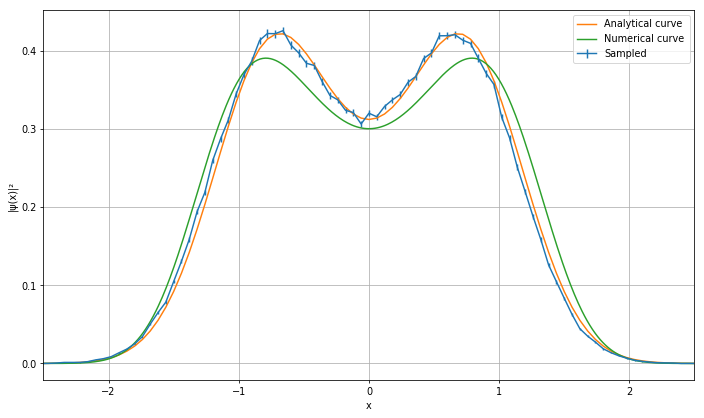

In [14]:
figure(num=None, figsize=(12, 7), dpi=70, facecolor='w', edgecolor='k')
plt.errorbar(x, y, yerr=err, label='Sampled')
plt.plot(x, y_exact, label='Analytical curve ')
plt.plot(x_num,(psi[0])**2, label='Numerical curve')
plt.xlabel("x")
plt.ylabel("|ψ(x)|²")
plt.legend(loc='best')
plt.grid(True)
plt.xlim((-2.5,2.5))
plt.show()

### Exercise 08.3

Use the PIMC/PIGS code we have provided to study the same 1D quantum system. Use the PIGS algorithm ($T=0$) to project
- a constant trial wave function, $\Psi_T(x)=1$

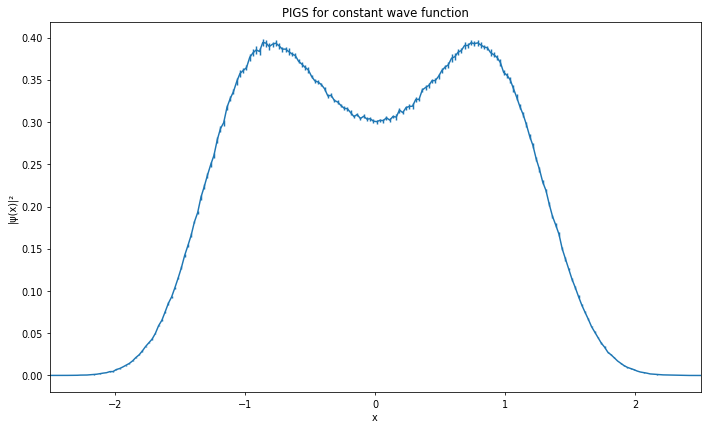

In [15]:
figure(num=None, figsize=(12, 7), dpi=70, facecolor='w', edgecolor='k')
pig_data = np.loadtxt('QMC_1D/probability_const.dat')
plt.errorbar(pig_data[:,0], pig_data[:,1], yerr=pig_data[:,2])
plt.title("PIGS for constant wave function")
plt.xlabel("x")
plt.ylabel("|ψ(x)|²")
plt.xlim((-2.5,2.5))
plt.show()

- using $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$ with the variational parameters you have optimized.

<span style="color:red">Compare your results with those obtained with your VMC code</span>. By using $\Psi_T^{\sigma,\mu}(x)$, how much can you reduce the imaginary time propagation with respect to the first case?

<span style="color:red">Finally, use the PIMC algorithm ($T>0$) to observe how the histogram with the sampled configurations changes by increasing the temperature.</span>

In [16]:
pig_data = np.loadtxt('QMC_1D/probability.dat')
pimc_data = np.loadtxt('QMC_1D/probability_1.dat')

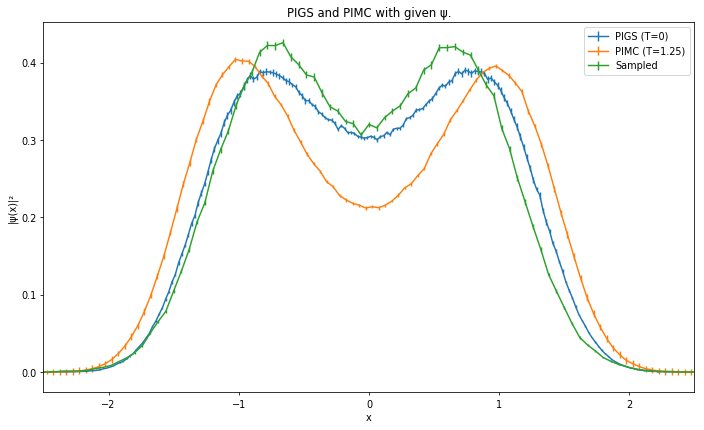

In [17]:
figure(num=None, figsize=(12, 7), dpi=70, facecolor='w', edgecolor='k')
plt.errorbar(pig_data[:,0], pig_data[:,1], yerr=pig_data[:,2], label='PIGS (T=0)')
plt.errorbar(pimc_data[:,0], pimc_data[:,1], yerr=pig_data[:,2], label='PIMC (T=1.25)')
plt.errorbar(x, y, yerr=err, label='Sampled')
plt.title("PIGS and PIMC with given ψ.")
plt.xlabel("x")
plt.ylabel("|ψ(x)|²")
plt.legend(loc='best')
plt.xlim((-2.5,2.5))
plt.show()

In [18]:
end_all = time()
print('Total run time: ', int((end_all - start_all)*100)/100, 'sec')

Total run time:  139.71 sec


------


---------

### Supplementary material

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.